In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

from typing import List, Dict

In [55]:
seed = 0

In [14]:
dataset = pd.read_csv("credit_risk_data_v2.csv")
dataset = dataset.dropna()

class ColumnSelectorTransformer:
    def __init__(self, columns: List[str]):
        self.columns = columns
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        return X.loc[:, self.columns]
    
    def fit(self, *args, **kwargs): 
        return self
    
    def __str__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    
    def __repr__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    

class BinningTransformer:
    def __init__(self, bins: Dict):
        self.bins = bins
        
    def __find_bin(self, value: float, mappings: List):
        for mapping in mappings:
            if value <= mapping["max"]:
                return mapping["label"]
        return "Error"
        
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        X = X.copy()
        for key in self.bins.keys():
            X.loc[:, key] = X.loc[:, key].transform(lambda x: self.__find_bin(x, self.bins[key]))
        return X

    def fit(self, *args, **kwargs):
        return self
    
    def __str__(self) -> str:
        return "BinningTransformer()"
    
    def __repr__(self) -> str:
        return "BinningTransformer()"

    
class WOETransformer:
    def __init__(self, columns: List[str], target_mappings: Dict = {0: "good", 1: "bad"}):
        self.target_mappings = target_mappings
        self.columns = columns
        self.woe_mappings = None
    
    def __get_absolute_odds(self, df: pd.DataFrame, col: str):
        key_first, key_second = list(self.target_mappings.keys())
        return (
            df.query(f"status=={key_first}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_first]})
            .set_index(col)
        ).join(
            df.query(f"status=={key_second}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_second]})
            .set_index(col)
        ).reset_index()[[col, "good", "bad"]]

    @staticmethod
    def __calculate_relative_odds(row: pd.Series, total_good: int, total_bad: int) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "good": row["good"] / total_good,
                "bad": row["bad"] / total_bad
            }
        )

    def __get_odds(self, df: pd.DataFrame, col: str,
                   absolute_values: bool = False) -> pd.DataFrame:
        key_first, key_second = list(self.target_mappings.keys())
        odds_absolute = self.__get_absolute_odds(df, col)

        if absolute_values:
            return odds_absolute

        # Relative Odds
        total_good = odds_absolute["good"].sum()
        total_bad = odds_absolute["bad"].sum()
        return odds_absolute.apply(
            lambda row: WOETransformer.__calculate_relative_odds(row, total_good, total_bad),
            axis=1
        )

    @staticmethod
    def __calculate_woe(row: pd.Series) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "woe": np.log(row["good"] / row["bad"]),
                "info_val": (row["good"] - row["bad"]) * np.log(row["good"] / row["bad"])
            }
        )

    def __set_woe_mappings(self, X: pd.DataFrame, y: pd.Series,
                           absolute_values: bool = False) -> None:
        df = X.copy()
        df["status"] = y
        
        self.woe_mappings = {
            col: self.__get_odds(df, col, absolute_values)\
                .apply(lambda row: WOETransformer.__calculate_woe(row), axis=1)\
                .sort_values(by="woe", axis=0, ascending=True)
            for col in self.columns
        }
        
    def fit(self, X: pd.DataFrame, y: pd.DataFrame, *args, **kwargs):
        self.__set_woe_mappings(X, y, *args, **kwargs)
        return self
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        if self.woe_mappings is None:
            raise NotFittedError(f"This {self} instance is not fitted yet. Call 'fit' with appropriate arguments before using this transformer.")
        df = X.copy()
        out = pd.DataFrame([])
        for col in df.columns:
            mapping = self.woe_mappings[col].set_index(col)
            categories = list(mapping.index)
            out[col] = df.loc[:, col].apply(lambda cat: mapping.loc[cat, "woe"])
        return out
    
    def __str__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"
    
    def __repr__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"
    
from bins import bins

In [15]:
x_train = dataset.drop("status", axis=1)
y_train = dataset["status"]

cols_to_keep = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 
                'annual_inc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                'total_rec_int', 'last_pymnt_amnt','home_ownership', 'verification_status']

## Transformations

In [16]:
column_t = ColumnSelectorTransformer(cols_to_keep)
binning_t = BinningTransformer(bins)
woe_t = WOETransformer(cols_to_keep)

In [17]:
x_train_c = column_t.transform(x_train)
x_train_c.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,home_ownership,verification_status
0,5000,5000,4975.0,36 months,10.65,162.87,24000.0,9.0,5861.071414,5831.78,5000.00,861.07,171.62,RENT,Verified
1,2500,2500,2500.0,60 months,15.27,59.83,30000.0,4.0,1008.710000,1008.71,456.46,435.17,119.66,RENT,Source Verified
2,2400,2400,2400.0,36 months,15.96,84.33,12252.0,10.0,3003.653644,3003.65,2400.00,603.65,649.91,RENT,Not Verified
3,10000,10000,10000.0,36 months,13.49,339.31,49200.0,37.0,12226.302210,12226.30,10000.00,2209.33,357.48,RENT,Source Verified
4,3000,3000,3000.0,60 months,12.69,67.79,80000.0,38.0,3242.170000,3242.17,2233.10,1009.07,67.79,RENT,Source Verified


In [18]:
x_train_b = binning_t.transform(x_train_c)
x_train_b.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,home_ownership,verification_status
0,"(37, 40)","(23, 83)","(29000, 33000)",36 months,"(558, 1254)","(37, 40)","(29000, 33000)","(-inf, 558)","(37, 40)","(37, 40)","(29000, 33000)","(12, 45)","(558, 1254)",RENT,Verified
1,"(37, 40)","(23, 83)","(29000, 33000)",60 months,"(1254, 1597)","(37, 40)","(29000, 33000)","(-inf, 558)","(37, 40)","(37, 40)","(-inf, 29000)","(12, 45)","(558, 1254)",RENT,Source Verified
2,"(37, 40)","(23, 83)","(29000, 33000)",36 months,"(1254, 1597)","(37, 40)","(29000, 33000)","(-inf, 558)","(37, 40)","(37, 40)","(29000, 33000)","(12, 45)","(558, 1254)",RENT,Not Verified
3,"(37, 40)","(23, 83)","(29000, 33000)",36 months,"(558, 1254)","(37, 40)","(29000, 33000)","(1254, 1597)","(40, 46)","(40, 46)","(33000, 42000)","(12, 45)","(558, 1254)",RENT,Source Verified
4,"(37, 40)","(23, 83)","(29000, 33000)",60 months,"(558, 1254)","(37, 40)","(33000, 42000)","(1254, 1597)","(37, 40)","(37, 40)","(29000, 33000)","(12, 45)","(558, 1254)",RENT,Source Verified


In [19]:
woe_t.fit(x_train_b, y_train)

WOETransformer(columns=['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'home_ownership', 'verification_status'], target_mappings={0: 'good', 1: 'bad'})

In [21]:
woe_t.transform(x_train_b).head()

KeyError: '(-inf, 37)'

## WOE

Now that we transformer our data to the respective Weight of Evidence, we can get the mappings for a given column to analyze the WoE and IV, and determine if our bins have a good predictive power, or if we need to re-structure them.

In [22]:
woe_t.woe_mappings["loan_amnt"]

,loan_amnt,good,bad,woe,info_val
2,"(40, 46)",0.443323,0.461591,-0.040382,7.377059e-04
1,"(37, 40)",0.556653,0.538389,0.033361,6.092971e-04
0,"(-inf, 37)",0.000024,0.000020,0.204745,9.127914e-07


In [23]:
woe_t.woe_mappings["funded_amnt"]

,funded_amnt,good,bad,woe,info_val
1,"(23, 83)",0.999976,0.99998,-0.000004,1.987591e-11
0,"(-inf, 23)",0.000024,0.00002,0.204745,9.127914e-07


In [24]:
woe_t.woe_mappings["funded_amnt_inv"]

,funded_amnt_inv,good,bad,woe,info_val
0,"(-inf, 29000)",0.000963,0.003355,-1.248039,0.002985
2,"(33000, 42000)",0.440147,0.453664,-0.030249,0.000409
1,"(29000, 33000)",0.558890,0.542980,0.028879,0.000459


In [25]:
woe_t.woe_mappings["term"]

,term,good,bad,woe,info_val
1,60 months,0.265293,0.356284,-0.294891,0.026832
0,36 months,0.734707,0.643716,0.132213,0.012030


In [26]:
woe_t.woe_mappings["int_rate"]

,int_rate,good,bad,woe,info_val
1,"(1597, inf)",0.000465,0.001393,-1.097830,0.001019
0,"(1254, 1597)",0.436561,0.661572,-0.415689,0.093534
2,"(558, 1254)",0.562974,0.337035,0.513046,0.115917


In [27]:
woe_t.woe_mappings["installment"]

,installment,good,bad,woe,info_val
0,"(-inf, 37)",0.000010,0.000020,-0.711546,0.000007
2,"(40, 46)",0.418420,0.439262,-0.048611,0.001013
1,"(37, 40)",0.581571,0.560718,0.036514,0.000761


In [28]:
woe_t.woe_mappings["annual_inc"]

,annual_inc,good,bad,woe,info_val
1,"(29000, 33000)",0.609744,0.703640,-0.143228,0.013449
2,"(33000, 42000)",0.389886,0.296184,0.274874,0.025756
3,"(47000, inf)",0.000368,0.000177,0.735373,0.000141
0,"(-inf, 29000)",0.000002,NaN,NaN,NaN


In [29]:
woe_t.woe_mappings["total_acc"]

,total_acc,good,bad,woe,info_val
0,"(-inf, 558)",0.075460,0.091416,-0.191810,0.003060
2,"(558, 1254)",0.490254,0.508074,-0.035704,0.000636
1,"(1254, 1597)",0.434286,0.400510,0.080964,0.002735


In [30]:
woe_t.woe_mappings["total_pymnt"]

,total_pymnt,good,bad,woe,info_val
0,"(37, 40)",0.574879,0.82952,-0.366688,0.093374
1,"(40, 46)",0.425116,0.17048,0.913745,0.232673
2,"(58, inf)",0.000005,NaN,NaN,NaN


In [31]:
woe_t.woe_mappings["total_pymnt_inv"]

,total_pymnt_inv,good,bad,woe,info_val
0,"(-inf, 37)",0.000445,0.003865,-2.160688,0.007389
1,"(37, 40)",0.577747,0.828451,-0.360422,0.090359
2,"(40, 46)",0.421803,0.167684,0.922459,0.234415
3,"(83, inf)",0.000005,NaN,NaN,NaN


In [32]:
woe_t.woe_mappings["total_rec_prncp"]

,total_rec_prncp,good,bad,woe,info_val
0,"(-inf, 29000)",0.009767,0.169842,-2.855896,0.457159
1,"(29000, 33000)",0.566068,0.747552,-0.278090,0.050469
2,"(33000, 42000)",0.424081,0.082606,1.635846,0.558601
3,"(47000, inf)",0.000084,NaN,NaN,NaN


In [33]:
woe_t.woe_mappings["total_rec_int"]

,total_rec_int,good,bad,woe,info_val
0,"(-inf, 12)",0.000188,0.007456,-3.681303,0.026757
1,"(12, 45)",0.651618,0.677543,-0.039015,0.001012
2,"(45, 71)",0.348194,0.315000,0.100187,0.003326


In [34]:
woe_t.woe_mappings["last_pymnt_amnt"]

,last_pymnt_amnt,good,bad,woe,info_val
0,"(-inf, 558)",0.003588,0.010007,-1.025720,0.006584
3,"(558, 1254)",0.714359,0.987521,-0.323812,0.088453
1,"(1254, 1597)",0.282050,0.002472,4.736943,1.324346
2,"(1597, inf)",0.000002,NaN,NaN,NaN


In [35]:
woe_t.woe_mappings["home_ownership"]

,home_ownership,good,bad,woe,info_val
3,OTHER,0.000347,0.000746,-0.765613,0.000305
2,NONE,0.000092,0.000157,-0.539696,0.000035
5,RENT,0.396568,0.466300,-0.161983,0.011296
4,OWN,0.089547,0.088590,0.010741,0.000010
1,MORTGAGE,0.513445,0.444207,0.144852,0.010029
0,ANY,0.000002,NaN,NaN,NaN


In [36]:
woe_t.woe_mappings["verification_status"]

,verification_status,good,bad,woe,info_val
2,Verified,0.353126,0.419994,-0.173416,0.011596
1,Source Verified,0.323571,0.306426,0.054441,0.000933
0,Not Verified,0.323303,0.273580,0.166998,0.008304


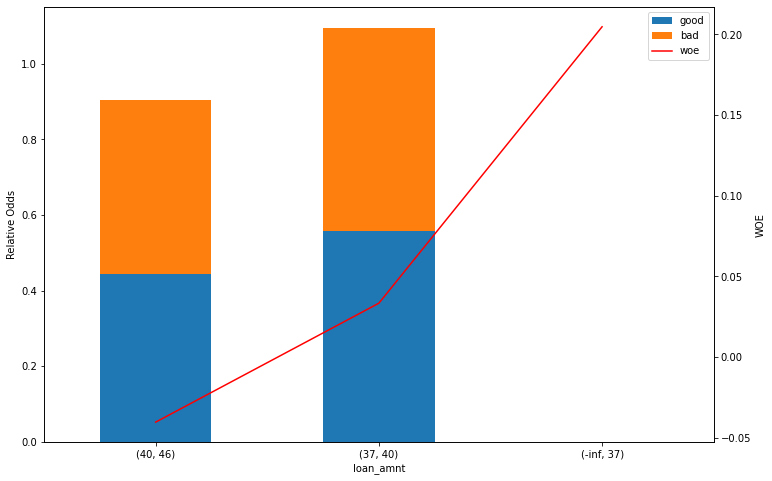

In [38]:
ax = woe_t.woe_mappings["loan_amnt"].plot.bar(
    x="loan_amnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["loan_amnt"].plot(
    x="loan_amnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

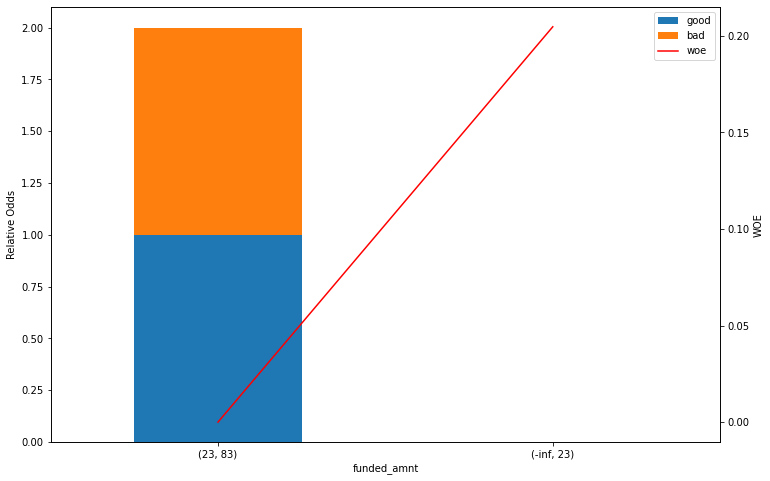

In [39]:
ax = woe_t.woe_mappings["funded_amnt"].plot.bar(
    x="funded_amnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["funded_amnt"].plot(
    x="funded_amnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

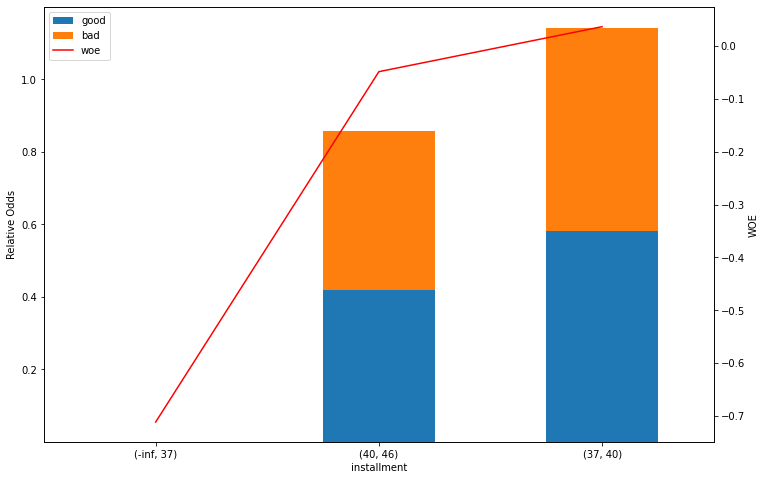

In [43]:
ax = woe_t.woe_mappings["installment"].plot.bar(
    x="installment", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["installment"].plot(
    x="installment", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

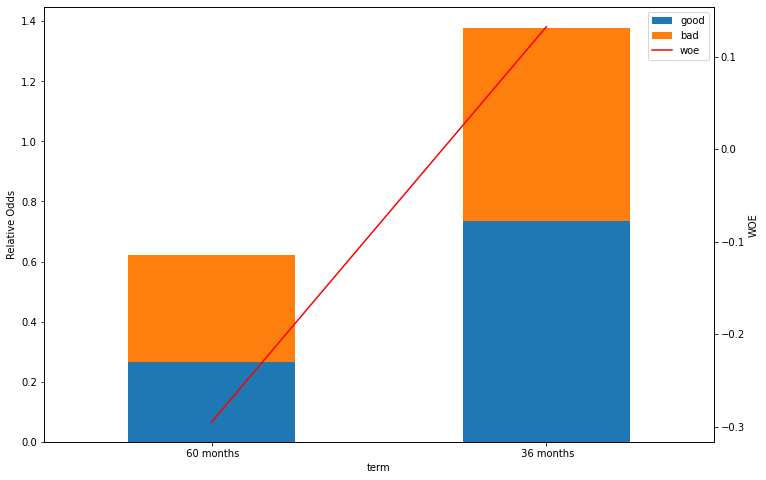

In [41]:
ax = woe_t.woe_mappings["term"].plot.bar(
    x="term", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["term"].plot(
    x="term", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

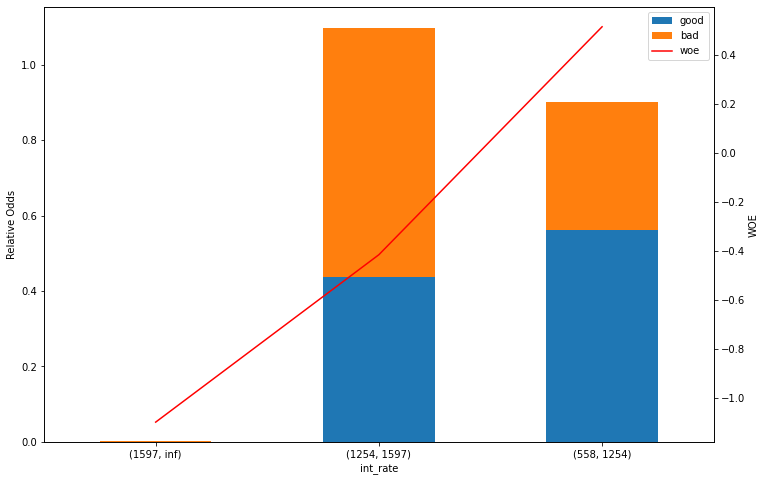

In [42]:
ax = woe_t.woe_mappings["int_rate"].plot.bar(
    x="int_rate", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["int_rate"].plot(
    x="int_rate", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

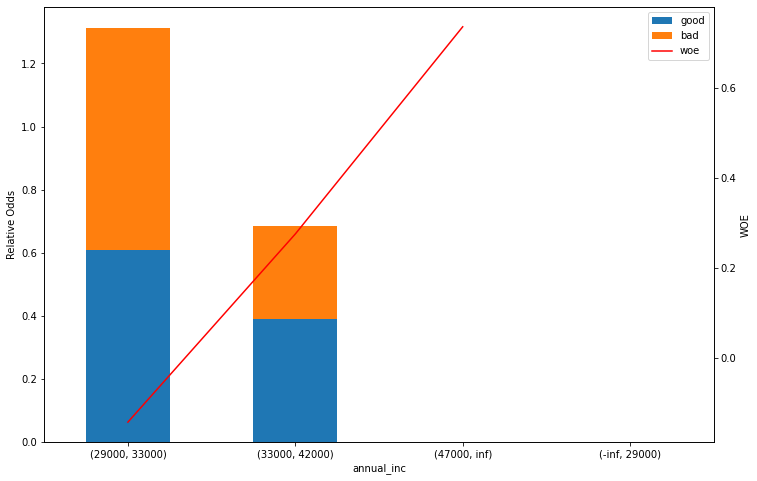

In [44]:
ax = woe_t.woe_mappings["annual_inc"].plot.bar(
    x="annual_inc", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["annual_inc"].plot(
    x="annual_inc", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

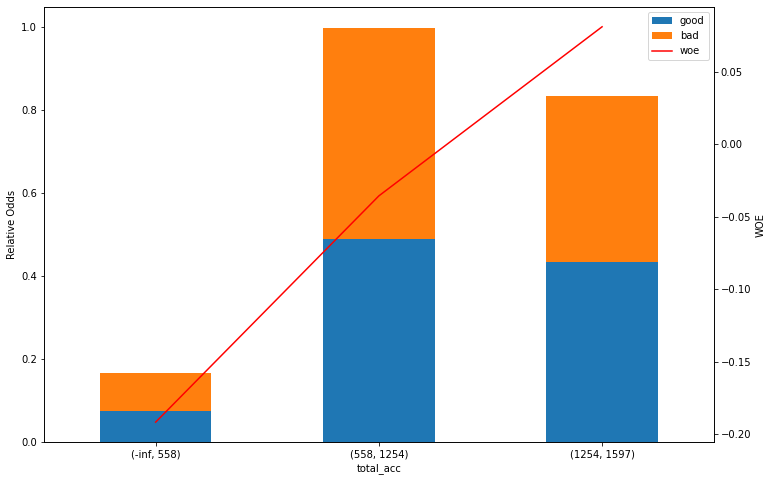

In [45]:
ax = woe_t.woe_mappings["total_acc"].plot.bar(
    x="total_acc", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_acc"].plot(
    x="total_acc", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

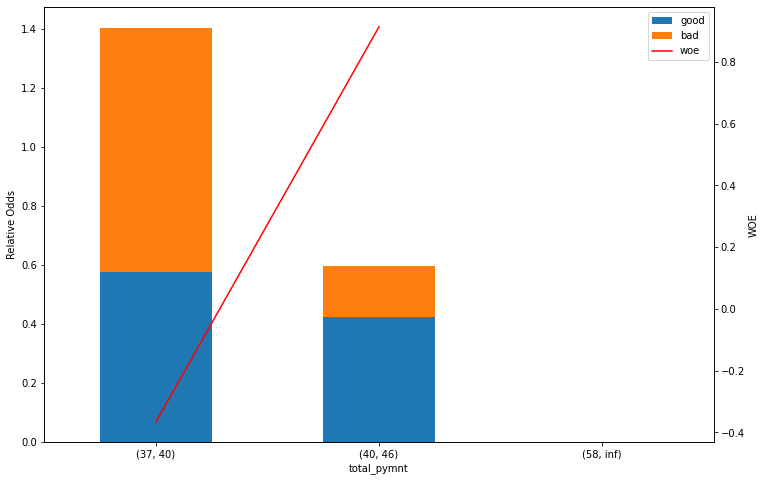

In [46]:
ax = woe_t.woe_mappings["total_pymnt"].plot.bar(
    x="total_pymnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_pymnt"].plot(
    x="total_pymnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

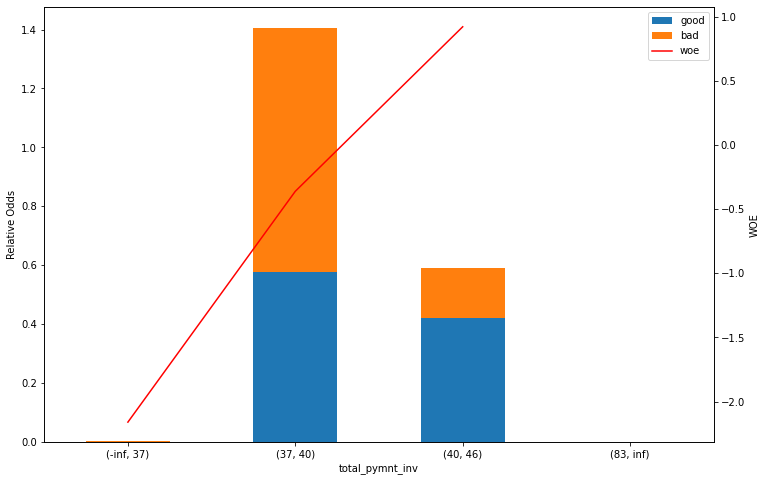

In [47]:
ax = woe_t.woe_mappings["total_pymnt_inv"].plot.bar(
    x="total_pymnt_inv", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_pymnt_inv"].plot(
    x="total_pymnt_inv", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

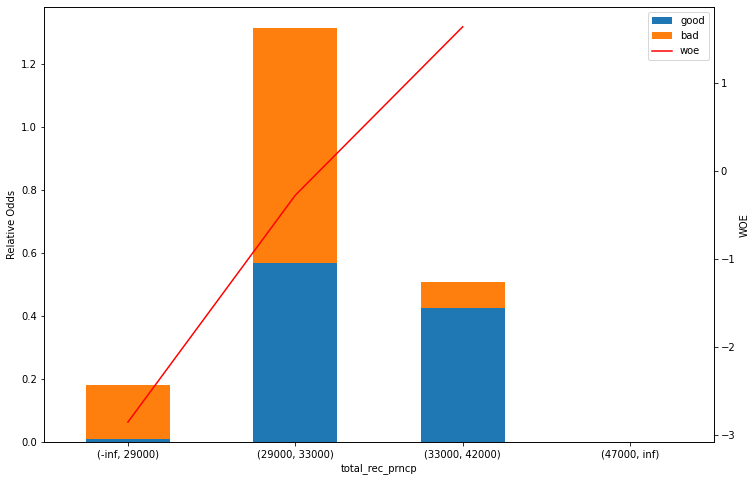

In [48]:
ax = woe_t.woe_mappings["total_rec_prncp"].plot.bar(
    x="total_rec_prncp", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_rec_prncp"].plot(
    x="total_rec_prncp", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

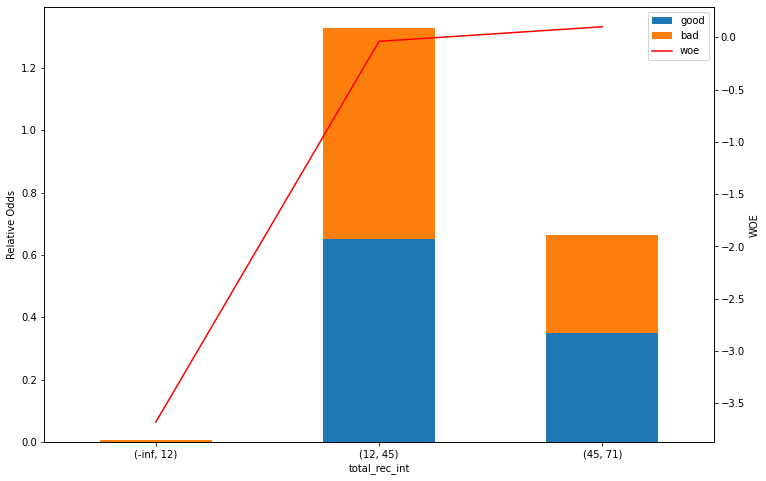

In [49]:
ax = woe_t.woe_mappings["total_rec_int"].plot.bar(
    x="total_rec_int", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_rec_int"].plot(
    x="total_rec_int", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

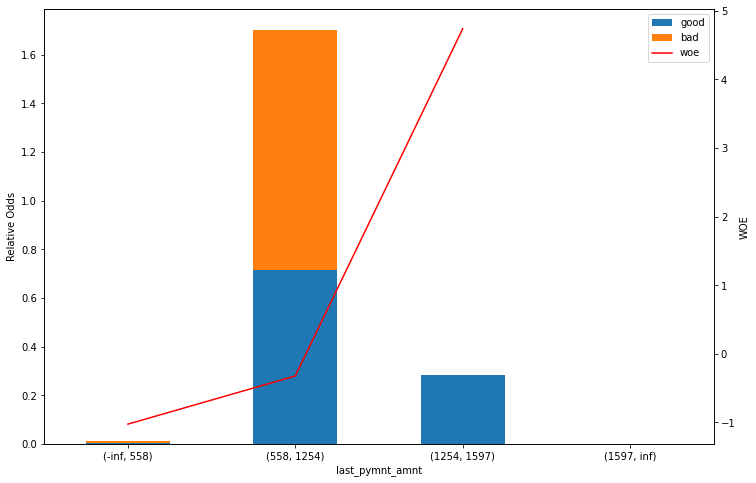

In [50]:
ax = woe_t.woe_mappings["last_pymnt_amnt"].plot.bar(
    x="last_pymnt_amnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["last_pymnt_amnt"].plot(
    x="last_pymnt_amnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

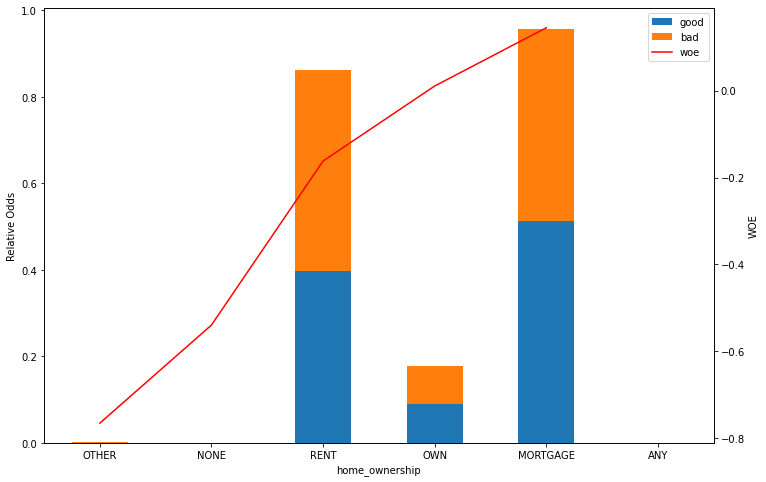

In [51]:
ax = woe_t.woe_mappings["home_ownership"].plot.bar(
    x="home_ownership", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["home_ownership"].plot(
    x="home_ownership", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

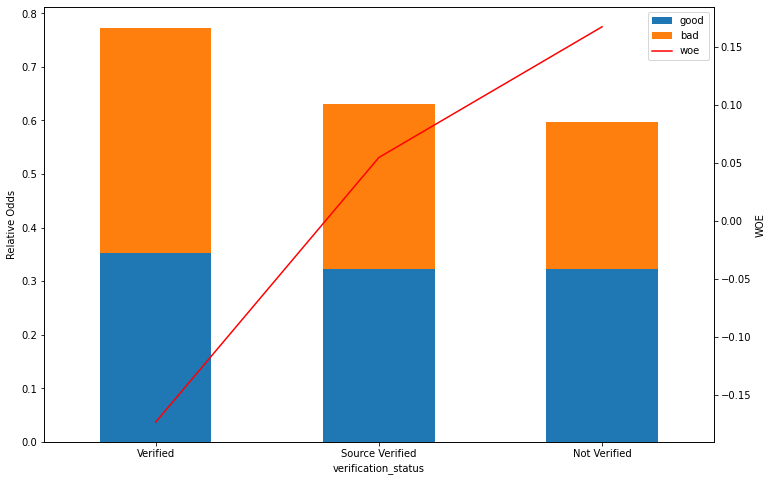

In [52]:
ax = woe_t.woe_mappings["verification_status"].plot.bar(
    x="verification_status", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["verification_status"].plot(
    x="verification_status", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

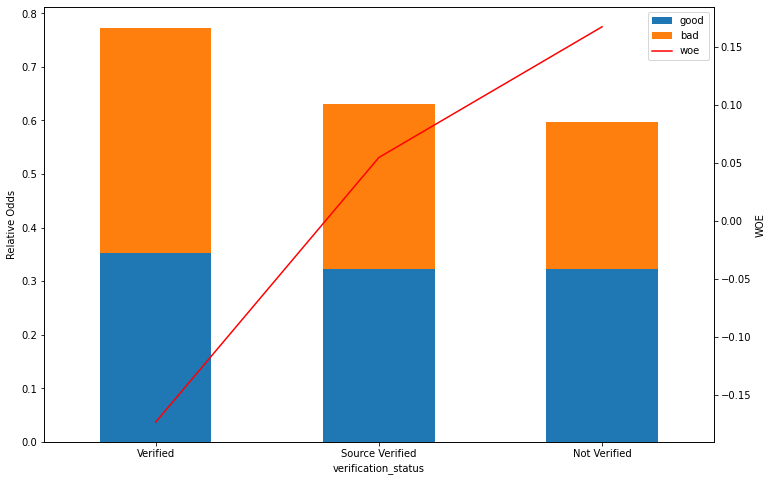

In [53]:
ax = woe_t.woe_mappings["verification_status"].plot.bar(
    x="verification_status", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["verification_status"].plot(
    x="verification_status", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

# Pipelines

We already defined our custom transformers, and since we added a `fit` and `transform` method, we are able to use `sklearn.pipelines` to stack the transformers and models into a single job that is dealing with raw data. 

In [56]:
ml_pipe = Pipeline([
    ('col selector', ColumnSelectorTransformer(columns=cols_to_keep)),
    ('bins', BinningTransformer(bins=bins)),
    ('woe', WOETransformer(columns=cols_to_keep)),
    # ('logistic regression', LogisticRegression(random_state=seed))
    ('gdbt', GradientBoostingClassifier(random_state=seed))
])

In [57]:
y_train_nd = [1 if val==0 else 0 for val in y_train.values]

In [58]:
ml_pipe.fit(x_train, y_train_nd)

KeyError: '(-inf, 29000)'

In [59]:
ml_pipe.score(x_train, y_train_nd)

KeyError: '(-inf, 29000)'

In [60]:
ml_pipe.predict_proba(x_train)

KeyError: '(-inf, 29000)'

In [61]:
y_pred = ml_pipe.predict(x_train)

KeyError: '(-inf, 29000)'

In [62]:
fpr, tpr, threshold = roc_curve(y_train_nd, ml_pipe.predict_proba(x_train)[:, 1])
roc_auc = auc(fpr, tpr)
f1 = f1_score(y_train_nd, y_pred)
print(f"ROC AUC: {roc_auc}")
print(f"F1: {f1}")

KeyError: '(-inf, 29000)'

NameError: name 'fpr' is not defined

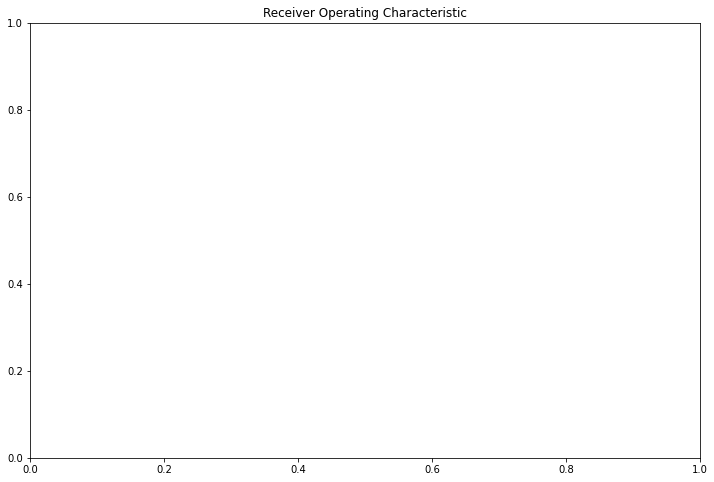

In [63]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [64]:
predictions = pd.DataFrame({"y_original": y_train_nd, "y_predicted": ml_pipe.predict_proba(x_train)[:, 1]})
predictions.head()

KeyError: '(-inf, 29000)'

In [ ]:
predictions.plot.hist(title="General Score Histogram", y="y_predicted", 
                      bins=10, alpha=0.8, figsize=(12, 8));

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

predictions[predictions["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

predictions[predictions["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");


In [ ]:
predictions[predictions["y_original"] == 0].mean()

In [ ]:
predictions[predictions["y_original"] == 1].mean()